In [2]:
# Tony Bui z5448625

import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from env import StaticGridEnv
from utils import plot_comparison_with_baseline

# Initialize env
env = StaticGridEnv(seed=42)
state = env.reset()
done = False

# Hyperparameters
alpha_qlearning = 0.2  # Learning rate
gamma_qlearning = 0.95  # Discount factor
initial_epsilon_qlearning = 0.3
epsilon_qlearning = initial_epsilon_qlearning  # Exploration rate
epsilon_min_qlearning = 0.01 # Minimum exploration rate
epsilon_decay_qlearning = 0.995 # Exponential decay rate for epsilon

alpha_sarsa = 0.3  # Learning rate
gamma_sarsa = 0.99  # Discount factor
initial_epsilon_sarsa = 0.4
epsilon_sarsa = initial_epsilon_sarsa  # Exploration rate
epsilon_min_sarsa = 0.01 # Minimum exploration rate
epsilon_decay_sarsa = 0.995 # Exponential decay rate for epsilon

num_episodes = 2000
max_steps = 100

# Teacher parameters
availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]  # Teacher availability levels
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]  # Teacher accuracy levels

# Stored metrics
average_reward_qlearning = 0
success_rate_qlearning = 0
learning_speed_qlearning = 0
average_reward_sarsa = 0
success_rate_sarsa = 0
learning_speed_sarsa = 0

pygame 2.6.1 (SDL 2.28.4, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Function to flatten the state (i, j) to a single index
def flatten_state(state):
    return state[0] * 10 + state[1]

# Function to choose action using epsilon-greedy strategy or teacher advice
def choose_action(state, q_table_teacher, q_table_student, epsilon, teacher_available, correct_advice):
    if teacher_available:
        if correct_advice:
            # Teacher provides correct advice, take the best action (exploit)
            return np.argmax(q_table_teacher[state, :])
        else:
            # Teacher provides incorrect advice, take a random action (explore)
            return random.choice([a for a in range(env.action_space) if a != np.argmax(q_table_teacher[state, :])])
    else:
        # No teacher advice, fall back to epsilon-greedy
        if np.random.uniform(0, 1) < epsilon:
            return random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(q_table_student[state, :])  # Exploit

In [ ]:
# Q-Learning

# Initialize Q-table for the flattened 10x10 grid world (100 states, 4 actions)
q_table_qlearning = np.zeros((10 * 10, 4))

# Training loop for different accuracy levels
total_rewards_per_episode = []
steps_per_episode = []
successful_episodes = 0

for episode in range(num_episodes):
    state = env.reset()  # Get the initial state (a tuple like (i, j))
    state = flatten_state(state)  # Flatten the state (i, j) -> single index
    done = False
    total_reward = 0
    steps = 0

    # Determine if teacher gives advice
    teacher_available = False
    correct_advice = False
    
    for step in range(max_steps):
        # Choose action based on teacher availability and advice
        action = choose_action(state, np.zeros((10 * 10, 4)), q_table_qlearning, epsilon_qlearning, teacher_available, correct_advice)
        
        # Execute the action
        next_state, reward, done, _ = env.step(action)
        
        # Flatten the next state for indexing
        next_state = flatten_state(next_state)
        
        # Update Q-table using Q-learning update rule
        q_table_qlearning[state, action] += alpha_qlearning * (reward + gamma_qlearning * np.max(q_table_qlearning[next_state, :]) - q_table_qlearning[state, action])

        total_reward += reward
        state = next_state
        steps += 1

        if done:
            if reward > 0:  # Goal reached
                successful_episodes += 1
            break

    total_rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    # Decay epsilon after each episode (exponential decay)
    epsilon_qlearning = max(epsilon_min_qlearning, epsilon_qlearning * epsilon_decay_qlearning)

q_table_qlearning = (q_table_qlearning - np.min(q_table_qlearning)) / (np.max(q_table_qlearning) - np.min(q_table_qlearning) + 1e-10)

epsilon_qlearning = initial_epsilon_qlearning

# Plot the cumulative reward over episodes
plt.figure(figsize=(10, 6))
plt.plot(total_rewards_per_episode, label="Cumulative Reward", color="blue")
plt.title('Cumulative Reward over Episodes (Q-Learning)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.legend()
plt.show()

# Calculate metrics
avg_reward = (sum(total_rewards_per_episode) / num_episodes)
success_rate = ((successful_episodes / num_episodes) * 100)
avg_learning_speed = (1/((1/num_episodes)*sum(steps_per_episode)))
average_reward_qlearning = avg_reward
success_rate_qlearning = success_rate
learning_speed_qlearning = avg_learning_speed

# Print the calculated metrics
print("Agent 1 Q-Learning")
print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward per Episode: {avg_reward:.2f}")
print(f"Average Learning Speed (Steps per Episode): {avg_learning_speed:.2f}")

# Close the environment
env.close()


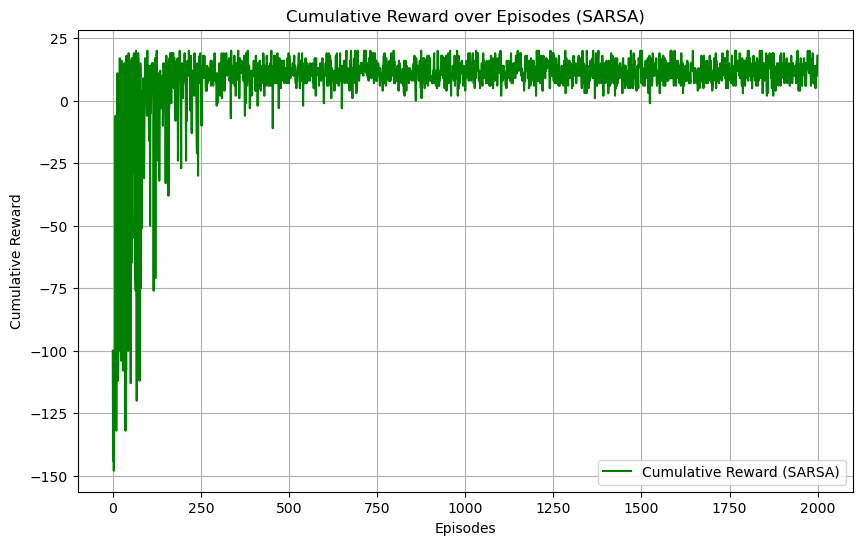

Agent 2 SARSA
Success Rate: 98.85%
Average Reward per Episode: 8.94
Average Learning Speed (Steps per Episode): 0.09


In [4]:
# SARSA

# Initialize Q-table for the flattened 10x10 grid world (100 states, 4 actions)
q_table_sarsa = np.zeros((10 * 10, 4))

# Training loop for different accuracy levels
total_rewards_per_episode = []
steps_per_episode = []
successful_episodes = 0

for episode in range(num_episodes):
    state = env.reset()  # Get the initial state (a tuple like (i, j))
    state = flatten_state(state)  # Flatten the state (i, j) -> single index
    done = False
    total_reward = 0
    steps = 0

    # Determine if teacher gives advice
    teacher_available = False
    correct_advice = False

    # SARSA: Choose initial action
    action = choose_action(state, np.zeros((10 * 10, 4)), q_table_sarsa, epsilon_sarsa, teacher_available, correct_advice)

    for step in range(max_steps):  
        # Execute the action
        next_state, reward, done, _ = env.step(action)
        
        # Flatten the next state for indexing
        next_state = flatten_state(next_state)

        # SARSA: Choose the next action using the same policy
        next_action = choose_action(next_state, np.zeros((10 * 10, 4)), q_table_sarsa, epsilon_sarsa, teacher_available, correct_advice)
        
        # Update Q-table using SARSA update rule
        q_table_sarsa[state, action] += alpha_sarsa * (reward + gamma_sarsa * q_table_sarsa[next_state, next_action] - q_table_sarsa[state, action])

        total_reward += reward
        state = next_state
        action = next_action  # Move to the next state-action pair
        steps += 1

        if done:
            if reward > 0:  # Goal reached
                successful_episodes += 1
            break

    total_rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    # Decay epsilon after each episode (exponential decay)
    epsilon_sarsa = max(epsilon_min_sarsa, epsilon_sarsa * epsilon_decay_sarsa)

epsilon_sarsa = initial_epsilon_sarsa

# Plot the cumulative reward over episodes
plt.figure(figsize=(10, 6))
plt.plot(total_rewards_per_episode, label="Cumulative Reward (SARSA)", color="green")
plt.title('Cumulative Reward over Episodes (SARSA)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.legend()
plt.show()

# Calculate metrics
avg_reward = (sum(total_rewards_per_episode) / num_episodes)
success_rate = ((successful_episodes / num_episodes) * 100)
avg_learning_speed = (1/((1/num_episodes)*sum(steps_per_episode)))
average_reward_sarsa = avg_reward
success_rate_sarsa = success_rate
learning_speed_sarsa = avg_learning_speed

# Print the calculated metrics
print("Agent 2 SARSA")
print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward per Episode: {avg_reward:.2f}")
print(f"Average Learning Speed (Steps per Episode): {avg_learning_speed:.2f}")

# Close the environment
env.close()


In [18]:
# Function to train a new agent with teacher advice
def train_with_teacher_qlearning(q_table_qlearning, teacher_available, correct_advice):  
    # Initialize metrics
    print(q_table_qlearning)
    q_table_student = np.zeros((10 * 10, 4))
    total_rewards_per_episode = []
    steps_per_episode = []
    successful_episodes = 0
    global epsilon_qlearning
    
    # Training loop
    for episode in range(num_episodes):
        state = env.reset()  # Get the initial state (a tuple like (i, j))
        state = flatten_state(state)  # Flatten the state (i, j) -> single index
        done = False
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            # Choose action based on teacher availability and advice
            action = choose_action(state, q_table_qlearning, q_table_student, epsilon_qlearning, teacher_available, correct_advice)
            
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            
            # Flatten the next state for indexing
            next_state = flatten_state(next_state)
            
            # Update Q-table using Q-learning update rule
            q_table_student[state, action] += alpha_qlearning * (reward + gamma_qlearning * np.max(q_table_student[next_state, :]) - q_table_student[state, action])

            total_reward += reward
            state = next_state
            steps += 1

            if done:
                if reward > 0:  # Goal reached
                    successful_episodes += 1
                break

        total_rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)

        # Decay epsilon after each episode (exponential decay)
        epsilon_qlearning = max(epsilon_min_qlearning, epsilon_qlearning * epsilon_decay_qlearning)

    epsilon_qlearning = initial_epsilon_qlearning
    
    # Calculate metrics
    avg_reward = (sum(total_rewards_per_episode) / num_episodes)
    success_rate = ((successful_episodes / num_episodes) * 100)
    avg_learning_speed = (1/((1/num_episodes)*sum(steps_per_episode)))

    return avg_reward, success_rate, avg_learning_speed

In [6]:
# Function to train a new agent with teacher advice
def train_with_teacher_sarsa(q_table_sarsa, teacher_available, correct_advice):  
    # Training loop for different accuracy levels
    q_table_student = np.zeros((10 * 10, 4))
    total_rewards_per_episode = []
    steps_per_episode = []
    successful_episodes = 0
    global epsilon_sarsa
    
    for episode in range(num_episodes):
        state = env.reset()  # Get the initial state (a tuple like (i, j))
        state = flatten_state(state)  # Flatten the state (i, j) -> single index
        done = False
        total_reward = 0
        steps = 0
    
        # SARSA: Choose initial action
        action = choose_action(state, q_table_sarsa, q_table_student, epsilon_sarsa, teacher_available, correct_advice)
    
        for step in range(max_steps):  
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            
            # Flatten the next state for indexing
            next_state = flatten_state(next_state)
    
            # SARSA: Choose the next action using the same policy
            next_action = choose_action(next_state, q_table_sarsa, q_table_student, epsilon_sarsa, teacher_available, correct_advice)
            
            # Update Q-table using Q-learning update rule
            q_table_student[state, action] += alpha_sarsa * (reward + gamma_sarsa * np.max(q_table_student[next_state, next_action]) - q_table_student[state, action])
    
            total_reward += reward
            state = next_state
            action = next_action  # Move to the next state-action pair
            steps += 1
    
            if done:
                if reward > 0:  # Goal reached
                    successful_episodes += 1
                break
    
        total_rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)

        # Decay epsilon after each episode (exponential decay)
        epsilon_sarsa = max(epsilon_min_sarsa, epsilon_sarsa * epsilon_decay_sarsa)

    epsilon_sarsa = initial_epsilon_sarsa
    
    
    # Calculate metrics
    avg_reward = (sum(total_rewards_per_episode) / num_episodes)
    success_rate = ((successful_episodes / num_episodes) * 100)
    avg_learning_speed = (1/((1/num_episodes)*sum(steps_per_episode)))
        
    return avg_reward, success_rate, avg_learning_speed

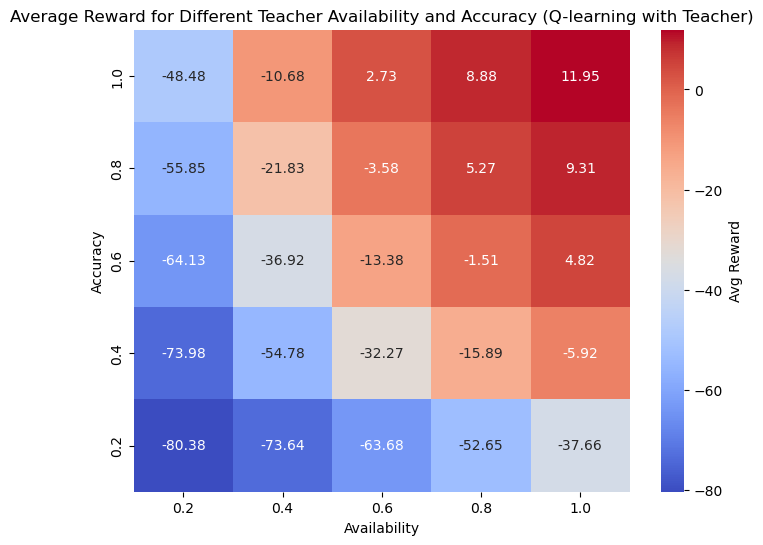

In [26]:
# Load the Q-table trained in Task 1 to be used as the teacher
teacher_q_table = q_table_qlearning
global alpha_qlearning
global gamma_qlearning
global initial_epsilon_qlearning
global epsilon_qlearning
global epsilon_min_qlearning
global epsilon_decay_qlearning

# Function to train the student agent with teacher advice
def train_student_with_teacher_qlearning(availability, accuracy):
    # Initialize Q-table for the student and metrics
    q_table_student = np.zeros((10 * 10, 4))
    epsilon_qlearning = initial_epsilon_qlearning
    total_rewards = []
    steps_per_episode = []
    successful_episodes = 0

    for episode in range(num_episodes):
        state = env.reset()
        state = flatten_state(state)
        total_reward = 0
        for step in range(max_steps):
            # Teacher advice based on availability and accuracy
            if np.random.rand() < availability:
                if np.random.rand() < accuracy:
                    # Correct advice: Use teacher's best action
                    action = np.argmax(teacher_q_table[state, :])
                else:
                    # Incorrect advice: Take a random action
                    action = np.random.randint(env.action_space)
            else:
                # No teacher advice: follow epsilon-greedy policy
                if np.random.rand() < epsilon_qlearning:
                    action = np.random.randint(env.action_space)
                else:
                    action = np.argmax(q_table_student[state, :])

            next_state, reward, done, _ = env.step(action)
            next_state = flatten_state(next_state)
            best_next_action = np.argmax(q_table_student[next_state, :])
            q_table_student[state, action] += alpha_qlearning * (
                reward + gamma_qlearning * q_table_student[next_state, best_next_action] - q_table_student[state, action]
            )

            # q_table_student = (q_table_student - np.min(q_table_student)) / (np.max(q_table_student) - np.min(q_table_student) + 1e-10)

            state = next_state
            total_reward += reward

            if done:
                successful_episodes += 1
                break

        epsilon_min = max(epsilon_min_qlearning, epsilon_qlearning * epsilon_decay_qlearning)
        total_rewards.append(total_reward)
        steps_per_episode.append(step + 1)

    # Calculate performance metrics
    success_rate = (successful_episodes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_learning_speed = 1 / np.mean(steps_per_episode)

    return avg_reward, success_rate, avg_learning_speed

# Run experiments and collect results
results = []
for availability in availability_values:
    for accuracy in accuracy_values:
        avg_reward, success_rate, avg_learning_speed = train_student_with_teacher_qlearning(availability, accuracy)
        results.append({
            "Availability": availability,
            "Accuracy": accuracy,
            "Avg Reward": avg_reward,
            "Success Rate (%)": success_rate,
            "Avg Learning Speed": avg_learning_speed
        })


# Convert results to DataFrame for analysis
df_results_qlearning = pd.DataFrame(results)

# Create a pivot table for heatmap using Average Reward
heatmap_data = df_results_qlearning.pivot(index="Accuracy", columns="Availability", values="Avg Reward")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Accuracy in descending order for y-axis

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Avg Reward'}
)
plt.title("Average Reward for Different Teacher Availability and Accuracy (Q-learning with Teacher)")
plt.xlabel("Availability")
plt.ylabel("Accuracy")
plt.show()


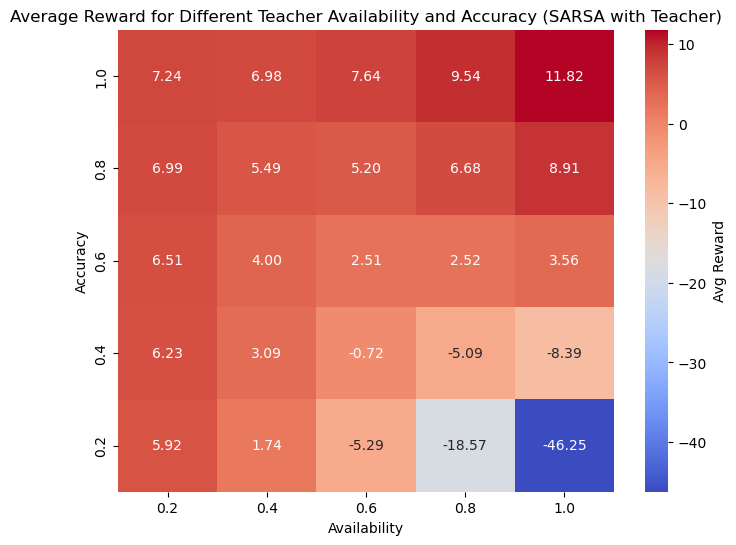

In [8]:
# Load the Q-table trained in Task 2 to be used as the teacher
teacher_q_table = q_table_sarsa
global alpha_sarsa
global gamma_sarsa
global initial_epsilon_sarsa
global epsilon_sarsa
global epsilon_min_sarsa
global epsilon_decay_sarsa

# Function to train the student agent with teacher advice using SARSA
def train_student_with_teacher_sarsa(availability, accuracy):
    # Initialize Q-table for the student and metrics
    q_table_student = np.zeros((10 * 10, 4))
    epsilon = initial_epsilon_sarsa
    total_rewards = []
    steps_per_episode = []
    successful_episodes = 0

    for episode in range(num_episodes):
        state = env.reset()
        state = flatten_state(state)
        total_reward = 0

        # Choose the initial action using epsilon-greedy or teacher advice
        if np.random.rand() < availability and np.random.rand() < accuracy:
            action = np.argmax(teacher_q_table[state, :])  # Correct advice
        elif np.random.rand() < availability:
            action = np.random.randint(env.action_space)  # Incorrect advice
        elif np.random.rand() < epsilon:
            action = np.random.randint(env.action_space)  # Exploration
        else:
            action = np.argmax(q_table_student[state, :])  # Exploitation

        for step in range(max_steps):
            # Take the action, observe the reward and next state
            next_state, reward, done, _ = env.step(action)
            next_state = flatten_state(next_state)
            total_reward += reward

            # Choose the next action in the new state
            if np.random.rand() < availability and np.random.rand() < accuracy:
                next_action = np.argmax(teacher_q_table[next_state, :])  # Correct advice
            elif np.random.rand() < availability:
                next_action = np.random.randint(env.action_space)  # Incorrect advice
            elif np.random.rand() < epsilon:
                next_action = np.random.randint(env.action_space)  # Exploration
            else:
                next_action = np.argmax(q_table_student[next_state, :])  # Exploitation

            # SARSA Q-table update
            q_table_student[state, action] += alpha_sarsa * (
                reward + gamma_sarsa * q_table_student[next_state, next_action] - q_table_student[state, action]
            )

            # Move to the next state and action
            state, action = next_state, next_action

            if done:
                successful_episodes += 1
                break

        epsilon = max(epsilon_min_sarsa, epsilon * epsilon_decay_sarsa)
        total_rewards.append(total_reward)
        steps_per_episode.append(step + 1)

    # Calculate performance metrics
    success_rate = (successful_episodes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_learning_speed = 1 / np.mean(steps_per_episode)

    return avg_reward, success_rate, avg_learning_speed

# Run experiments and collect results
results = []
for availability in availability_values:
    for accuracy in accuracy_values:
        avg_reward, success_rate, avg_learning_speed = train_student_with_teacher_sarsa(availability, accuracy)
        results.append({
            "Availability": availability,
            "Accuracy": accuracy,
            "Avg Reward": avg_reward,
            "Success Rate (%)": success_rate,
            "Avg Learning Speed": avg_learning_speed
        })


# Convert results to DataFrame for analysis
df_results_sarsa = pd.DataFrame(results)

# Create a pivot table for heatmap using Average Reward
heatmap_data = df_results_sarsa.pivot(index="Accuracy", columns="Availability", values="Avg Reward")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Accuracy in descending order for y-axis

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Avg Reward'}
)
plt.title("Average Reward for Different Teacher Availability and Accuracy (SARSA with Teacher)")
plt.xlabel("Availability")
plt.ylabel("Accuracy")
plt.show()

Q-Learning Baseline:
  Average Reward: 8.828
  Success Rate (%): 98.65
  Average Learning Speed (Steps per Episode): 0.08558346527450897

SARSA Baseline:
  Average Reward: 8.9375
  Success Rate (%): 98.85000000000001
  Average Learning Speed (Steps per Episode): 0.08634832915983076



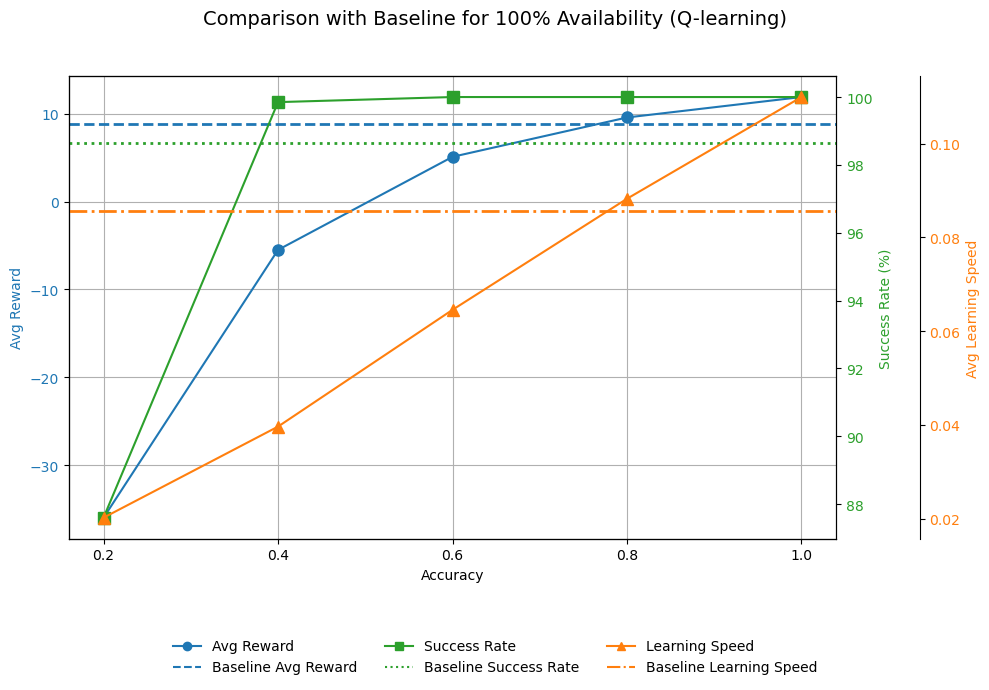

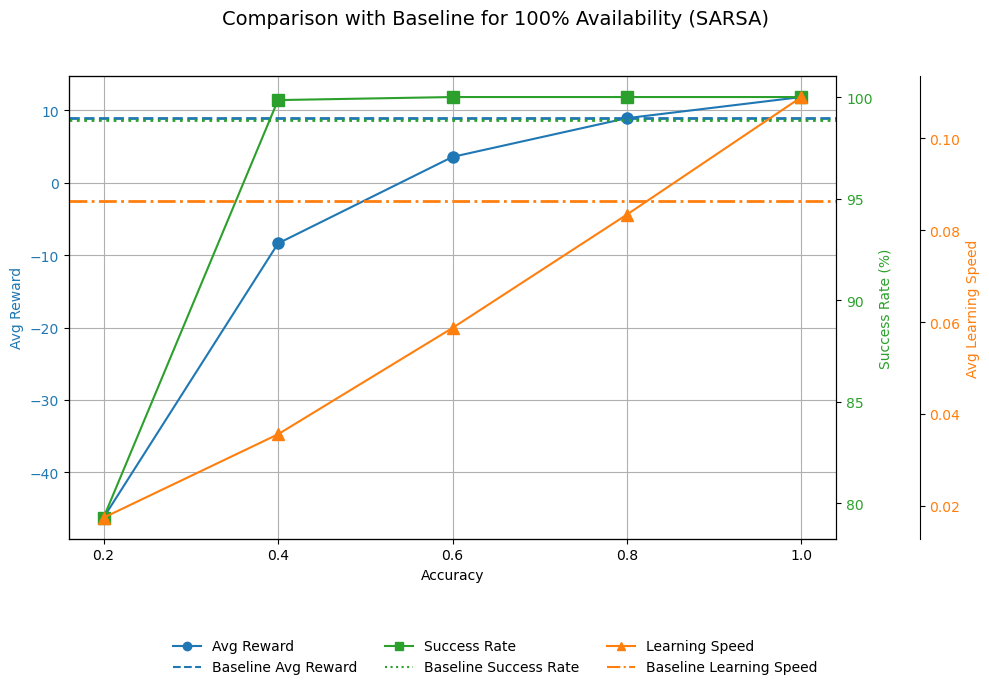

In [9]:
# Loading Results
baseline_learning_qlearning = (average_reward_qlearning, success_rate_qlearning, learning_speed_qlearning)
baseline_learning_sarsa = (average_reward_sarsa, success_rate_sarsa, learning_speed_sarsa)
print(f"Q-Learning Baseline:\n"
      f"  Average Reward: {average_reward_qlearning}\n"
      f"  Success Rate (%): {success_rate_qlearning}\n"
      f"  Average Learning Speed (Steps per Episode): {learning_speed_qlearning}\n")

print(f"SARSA Baseline:\n"
      f"  Average Reward: {average_reward_sarsa}\n"
      f"  Success Rate (%): {success_rate_sarsa}\n"
      f"  Average Learning Speed (Steps per Episode): {learning_speed_sarsa}\n")

# Convert baseline results to a DataFrame
baseline_results = {
    "Algorithm": ["Q-learning", "SARSA"],
    "Average Reward": [average_reward_qlearning, average_reward_sarsa],
    "Success Rate (%)": [success_rate_qlearning, success_rate_sarsa],
    "Average Learning Speed (Steps per Episode)": [learning_speed_qlearning, learning_speed_sarsa],
}

df_baseline = pd.DataFrame(baseline_results)

# Save the baseline results to a CSV file
df_baseline.to_csv("baseline_results.csv", index=False)

# Save the DataFrames for Task 3 and Task 4
df_results_qlearning.to_csv("results_qlearning.csv", index=False)
df_results_sarsa.to_csv("results_sarsa.csv", index=False)

availability = 1
plot_comparison_with_baseline(
    availability,
    df_learning=df_results_qlearning,
    baseline_learning=baseline_learning_qlearning,
    accuracies=accuracy_values,
    algorithm="Q-learning",
)

plot_comparison_with_baseline(
    availability,
    df_learning=df_results_sarsa,
    baseline_learning=baseline_learning_sarsa,
    accuracies=accuracy_values,
    algorithm="SARSA",
)